# Whales with fastai

## Reading libaries

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
import sys
sys.path.append("../../dl1")

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import pandas as pd

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## Data cleaning and preparation

In [6]:
data_PATH = "data/"
tmp_PATH = "tmp/"

In [7]:
!ls {data_PATH}

models	test  test.csv	tmp  train  train.csv


In [8]:
data = pd.read_csv(f'{data_PATH}train.csv')
data.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


data/train/0000e88ab.jpg


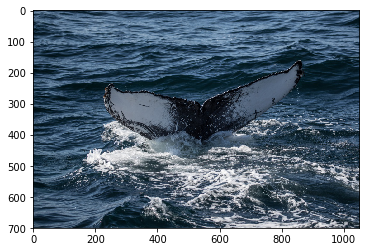

In [9]:
print(f'{data_PATH}train/{data["Image"][0]}')
img = plt.imread(f'{data_PATH}train/{data["Image"][0]}')
plt.imshow(img);
plt.show()
plt.close()

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64


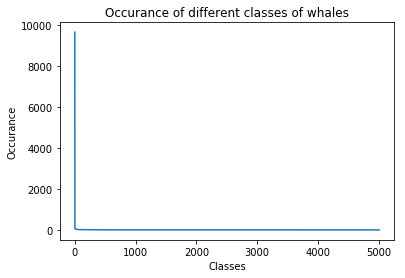

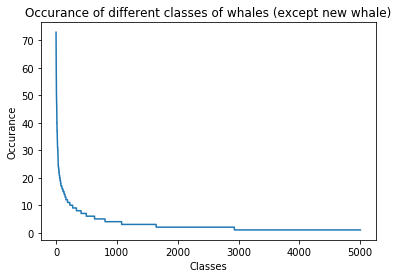

In [10]:
## Simple plots showing occurance of classes (train)

print(data.Id.value_counts().head())

plt.plot(list(data.Id.value_counts()))
plt.xlabel("Classes")
plt.ylabel("Occurance")
plt.title("Occurance of different classes of whales")
plt.show()
plt.close()

plt.plot(list(data.Id.value_counts())[1:])
plt.xlabel("Classes")
plt.ylabel("Occurance")
plt.title("Occurance of different classes of whales (except new whale)")
plt.show()
plt.close()

In [11]:
print(len(np.unique(data.Id)))
print(len((data.Id)))

5005
25361


In [12]:
## Cleaning data (removing new whale)

print(data.Id.value_counts().head())
data = data[data['Id'] != 'new_whale']
print(data.Id.value_counts().head())

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64
w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
Name: Id, dtype: int64


In [13]:
## Getting rid of any whales with less than N occurance

N = 1
q1 = (data.Id.value_counts()>N)
q2 = list(q1.loc[q1.iloc[:] == True].index)
q3 = (data.Id.value_counts()<=N)
q4 = list(q3.loc[q3.iloc[:] == True].index)
print(len(np.unique(q4)))

print(data.Id.value_counts().tail())
data = data[data['Id'].isin(q2)]
print(data.Id.value_counts().tail())

2073
w_45a768c    1
w_7ed8dac    1
w_d285a7a    1
w_2ac2bac    1
w_277d911    1
Name: Id, dtype: int64
w_ec64e27    2
w_98e83cc    2
w_780c931    2
w_5831e13    2
w_6e999b0    2
Name: Id, dtype: int64


In [14]:
print(len(np.unique(data.Id)))
print(len((data.Id)))

2931
13624


In [15]:
data.to_csv("tmp/newdatacsv.csv", sep=',', index=False)

In [16]:
n = len(data)-1
print(n)
val_idxs = get_cv_idxs(n, seed=42) # random 20% data for validation set
print(val_idxs)

13623
[ 7635   811  4850 ... 10315 12675 11944]


In [17]:
sz=299
bs=32
arch=resnext50
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
fastai_data = ImageClassifierData.from_csv(data_PATH, 'train', f'{tmp_PATH}newdatacsv.csv', test_name='test',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)

In [18]:
size_d = {k: PIL.Image.open(data_PATH + k).size for k in fastai_data.trn_ds.fnames}

In [19]:
row_sz, col_sz = list(zip(*size_d.values()))

In [20]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

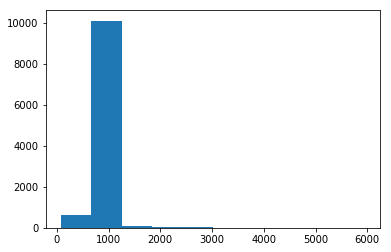

In [21]:
plt.hist(row_sz);

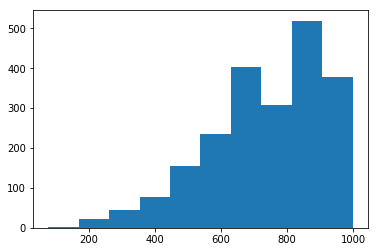

In [22]:
plt.hist(row_sz[row_sz<1000]);

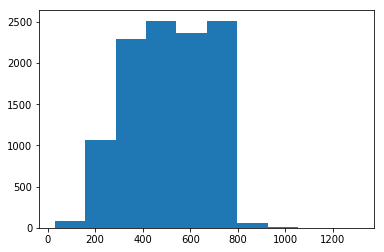

In [23]:
plt.hist(col_sz);

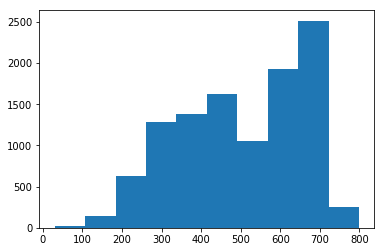

In [24]:
plt.hist(col_sz[col_sz<800]);

## Fastai

In [25]:
sz=400
bs=32
arch=resnext50

In [26]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    fastai_data = ImageClassifierData.from_csv(data_PATH, 'train', f'{tmp_PATH}newdatacsv.csv', test_name='test',
                                       val_idxs=val_idxs, tfms=tfms, bs=bs)

    return fastai_data

In [27]:
fastai_data = get_data(sz, bs)
learn=ConvLearner.pretrained(arch, fastai_data, precompute=False)

In [28]:
fastai_data = fastai_data.resize(int(sz*1.3), 'tmp')

In [29]:
lrf=learn.lr_find()

 90%|█████████ | 308/341 [06:31<00:41,  1.26s/it, loss=26.3]

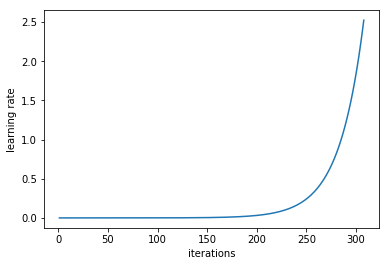

In [30]:
learn.sched.plot_lr()

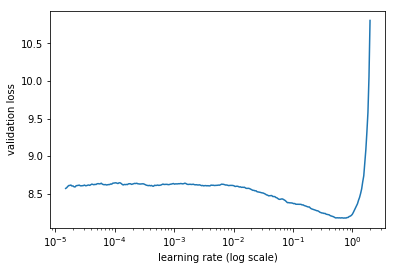

In [31]:
learn.sched.plot()

In [32]:
learn.fit(1e-1, 6)

epoch      trn_loss   val_loss   accuracy                   
    0      7.341556   7.121185   0.048458  
    1      6.600208   6.763977   0.061307                   
    2      5.983906   6.555777   0.083333                   
    3      5.495108   6.391057   0.096916                   
    4      5.023568   6.398243   0.098385                   
    5      4.629095   6.374019   0.110866                   


[array([6.37402]), 0.11086637298091043]

In [33]:
#fastai_data = get_data(388, bs)
precompute=False

 87%|████████▋ | 298/341 [07:18<00:55,  1.29s/it, loss=12.7]

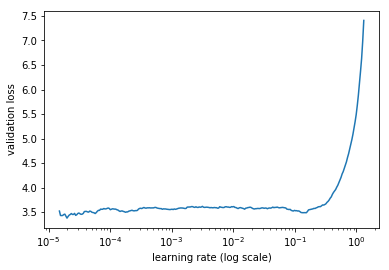

In [34]:
lrf=learn.lr_find()
learn.sched.plot()

In [35]:
%time learn.fit(5e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      3.333235   6.429923   0.135095  
    1      3.104367   6.512085   0.136197                   
CPU times: user 53min 10s, sys: 1h 17min 47s, total: 2h 10min 57s
Wall time: 17min 37s


[array([6.51208]), 0.13619676945668135]

In [36]:
learn.unfreeze()
lr=np.array([5e-4,5e-3,5e-2])

In [37]:
lrf=learn.lr_find()

  0%|          | 0/341 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [ ]:
learn.sched.plot()

In [ ]:
%time learn.fit(2e-3, 4, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('standard_resnet34_whale5')

## Loading and predicting

In [ ]:
learn.load('standard_resnet34_whale5')

In [ ]:
print(len(np.unique(data["Id"])))

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs,y)

In [ ]:
np.shape(probs)

In [ ]:
#preds = np.argmax(probs, axis=1)
#probs = probs[:,1]

#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y, preds)

#plot_confusion_matrix(cm, data.classes)

In [ ]:
#def get_data(sz, bs): # sz: image size, bs: batch size
#    tfms = tfms_from_model(arch, sz, max_zoom=1.1)
#    data = ImageClassifierData.from_arrays(tmp_PATH, trn=(train_x, train_y), val=(val_x, val_y),
#                                           test=test_x, classes=classes, tfms=tfms, bs=bs, num_workers=8)
#    return data

In [ ]:
#learn.set_data(get_data(sz,bs))
#data = get_data(sz,bs)
log_preds_test,y_test = learn.TTA(is_test=True)
probs_test = np.mean(np.exp(log_preds_test),0)
#preds_test = np.argmax(probs_test, axis=1)

In [ ]:
np.shape(probs_test)

In [ ]:
#preds_test_hold = np.argmax(probs_test, axis=1)
#print(preds_test_hold[0])
#plt.imshow(fastai_data.val_ds[0])

## Whale specific metrics

In [ ]:
print(np.shape(probs_test))

In [ ]:
myclasses = fastai_data.classes
print(len(fastai_data.classes))

In [ ]:
fastai_data.classes

In [ ]:
mydic = {k: fastai_data.classes[k] for k in range(0,len(fastai_data.classes))}
mydic

In [ ]:
mydic[0]

In [ ]:
## Val

mypred5 = (np.argsort(probs,axis=1)[:,::-1])[:,0:5]
mypred5_values = (np.sort(probs,axis=1)[:,::-1])[:,0:5]
print(np.shape(mypred5), np.shape(mypred5_values))
mypred5_pd = pd.DataFrame(mypred5)
mypred5_values_pd = pd.DataFrame(mypred5_values)
mypred5_pd.head()

In [ ]:
mypred5_pd = mypred5_pd.applymap(lambda x: mydic[x])
mypred5_pd.head()

In [ ]:
## test

mypred5_test = (np.argsort(probs_test,axis=1)[:,::-1])[:,0:5]
mypred5_values_test = (np.sort(probs_test,axis=1)[:,::-1])[:,0:5]
print(np.shape(mypred5_test), np.shape(mypred5_values_test))
mypred5_test_pd = pd.DataFrame(mypred5_test)
mypred5_values_test_pd = pd.DataFrame(mypred5_values_test)
mypred5_test_pd.head()

In [ ]:
mypred5_test_pd = mypred5_test_pd.applymap(lambda x: mydic[x])
mypred5_test_pd.head()

In [ ]:
## Adding new whale (val) (relative)
threshold = 0.3
no_of_newwhales = 0
for i in range(0,np.shape(mypred5_pd)[0]):
    if mypred5_values_pd.iloc[i,0] < threshold:
        no_of_newwhales += 1
        mypred5_pd.iloc[i,4] = mypred5_pd.iloc[i,3]
        mypred5_pd.iloc[i,3] = mypred5_pd.iloc[i,2]
        mypred5_pd.iloc[i,2] = mypred5_pd.iloc[i,1]
        mypred5_pd.iloc[i,1] = mypred5_pd.iloc[i,0]
        mypred5_pd.iloc[i,0] = 'new_whale'
    elif mypred5_values_pd.iloc[i,1] < threshold:
        no_of_newwhales += 1
        mypred5_pd.iloc[i,4] = mypred5_pd.iloc[i,3]
        mypred5_pd.iloc[i,3] = mypred5_pd.iloc[i,2]
        mypred5_pd.iloc[i,2] = mypred5_pd.iloc[i,1]
        mypred5_pd.iloc[i,1] = 'new_whale'
    elif mypred5_values_pd.iloc[i,2] < threshold:
        no_of_newwhales += 1
        mypred5_pd.iloc[i,4] = mypred5_pd.iloc[i,3]
        mypred5_pd.iloc[i,3] = mypred5_pd.iloc[i,2]
        mypred5_pd.iloc[i,2] = 'new_whale'
    elif mypred5_values_pd.iloc[i,3] < threshold:
        no_of_newwhales += 1
        mypred5_pd.iloc[i,4] = mypred5_pd.iloc[i,3]
        mypred5_pd.iloc[i,3] = 'new_whale'
    elif mypred5_values_pd.iloc[i,4] < threshold:
        no_of_newwhales += 1
        mypred5_pd.iloc[i,4] = 'new_whale'

print(no_of_newwhales)
mypred5_pd.head(15)

In [ ]:
## Adding new whale (test) (relative)
threshold = 0.3
no_of_newwhales = 0
for i in range(0,np.shape(mypred5_test_pd)[0]):
    if mypred5_values_test_pd.iloc[i,0] < threshold:
        no_of_newwhales += 1
        mypred5_test_pd.iloc[i,4] = mypred5_test_pd.iloc[i,3]
        mypred5_test_pd.iloc[i,3] = mypred5_test_pd.iloc[i,2]
        mypred5_test_pd.iloc[i,2] = mypred5_test_pd.iloc[i,1]
        mypred5_test_pd.iloc[i,1] = mypred5_test_pd.iloc[i,0]
        mypred5_test_pd.iloc[i,0] = 'new_whale'
    elif mypred5_values_test_pd.iloc[i,1] < threshold:
        no_of_newwhales += 1
        mypred5_test_pd.iloc[i,4] = mypred5_test_pd.iloc[i,3]
        mypred5_test_pd.iloc[i,3] = mypred5_test_pd.iloc[i,2]
        mypred5_test_pd.iloc[i,2] = mypred5_test_pd.iloc[i,1]
        mypred5_test_pd.iloc[i,1] = 'new_whale'
    elif mypred5_values_test_pd.iloc[i,2] < threshold:
        no_of_newwhales += 1
        mypred5_test_pd.iloc[i,4] = mypred5_test_pd.iloc[i,3]
        mypred5_test_pd.iloc[i,3] = mypred5_test_pd.iloc[i,2]
        mypred5_test_pd.iloc[i,2] = 'new_whale'
    elif mypred5_values_test_pd.iloc[i,3] < threshold:
        no_of_newwhales += 1
        mypred5_test_pd.iloc[i,4] = mypred5_test_pd.iloc[i,3]
        mypred5_test_pd.iloc[i,3] = 'new_whale'
    elif mypred5_values_test_pd.iloc[i,4] < threshold:
        no_of_newwhales += 1
        mypred5_test_pd.iloc[i,4] = 'new_whale'

print(no_of_newwhales)
mypred5_test_pd.head(15)

In [ ]:
mypred5_values_pd.iloc[:,0].head(15)

In [ ]:
## Score MAP5 (CV)

val_y = fastai_data.val_y
val_y_pd = pd.DataFrame(val_y)
val_y_pd = val_y_pd.applymap(lambda x: mydic[x])
print(mypred5_pd.iloc[:10,:])
print(mypred5_values_pd.iloc[:10,0])
print(val_y_pd.iloc[:10,0])

In [ ]:
## Score accuracy (CV)

score = 0
for i in range(0,np.shape(mypred5_pd)[0]):
    if (val_y_pd.iloc[i,0] == mypred5_pd.iloc[i,0]):
        score += 1

percentage = float(score)/float(np.shape(mypred5_pd)[0])
print(score)
print(percentage)

In [ ]:
map5 = 0
for i in range(0,np.shape(mypred5_pd)[0]):
    if (val_y_pd.iloc[i,0] == mypred5_pd.iloc[i,0]):
        map5 = map5 + 1.0
    elif (val_y_pd.iloc[i,0] == mypred5_pd.iloc[i,1]):
        map5 = map5 + 0.5
    elif (val_y_pd.iloc[i,0] == mypred5_pd.iloc[i,2]):
        map5 = map5 + 0.33
    elif (val_y_pd.iloc[i,0] == mypred5_pd.iloc[i,3]):
        map5 = map5 + 0.25
    elif (val_y_pd.iloc[i,0] == mypred5_pd.iloc[i,4]):
        map5 = map5 + 0.2

map5 = float(map5)/float(np.shape(mypred5_pd)[0])
print(map5)

## Creating Kaggle submission file

In [ ]:
test_filenames = fastai_data.test_ds.fnames; fastai_data.test_ds.fnames

In [ ]:
## Printing Prediction CSV (Test)
idpred = []
for i in range(0,np.shape(mypred5_test_pd)[0]):
    idpred.append(str(mypred5_test_pd.iloc[i,0]) + ' ' + str(mypred5_test_pd.iloc[i,1]) + ' ' + str(mypred5_test_pd.iloc[i,2]) + ' ' + str(mypred5_test_pd.iloc[i,3]) + ' ' + str(mypred5_test_pd.iloc[i,4]))
idpred_pd = pd.DataFrame(idpred, columns=["Id"])
test_filenames_pd = pd.DataFrame(test_filenames, columns=["Image"])
test_filenames_pd["Image"] = test_filenames_pd["Image"].str[5:]

shell = [test_filenames_pd, idpred_pd]
result = pd.concat(shell, axis=1, sort=False)
result.head()

In [ ]:
result.to_csv('prediction3.csv', sep=',', index=False, header=False)

## DO NOT USE BELOW!

In [ ]:
## Printing Prediction CSV (Test)
idpred = []
for i in range(0,np.shape(mypred5_test_pd)[0]):
    idpred.append(str(mypred5_test_pd.iloc[i,0]) + ' ' + str(mypred5_test_pd.iloc[i,1]) + ' ' + str(mypred5_test_pd.iloc[i,2]) + ' ' + str(mypred5_test_pd.iloc[i,3]) + ' ' + str(mypred5_test_pd.iloc[i,4]))

df_print = pd.read_csv(f'{data_PATH}test.csv')
df_print['Id'] = idpred
df_print.head()
df_print.to_csv('prediction.csv', sep=',', index=False)

In [ ]:
np.shape(preds_test)

In [ ]:
preds_test_pd = pd.DataFrame(preds_test, columns=["Label"])

ImageId = []
for i in range(0,np.shape(preds_test_pd)[0]):
    ImageId.append(i+1)

ImageId_pd = pd.DataFrame(ImageId, columns=["ImageId"])

In [ ]:
ImageId_pd.head()

In [ ]:
preds_test_pd.head()

In [ ]:
shell = [ImageId_pd,preds_test_pd]
result = pd.concat(shell, axis=1, sort=False)
result.head()

In [ ]:
result.to_csv("prediction.csv", sep=',', index=False)